In [5]:
import os
import pandas as pd
import numpy as np
from datetime import date, timedelta
from pandas.tseries.offsets import BMonthEnd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def readPayments(file_name, date_header="PaymentDate"):
    dataLoc = os.path.join(current_wd, "..", "data", file_name)
    paymentsData = pd.read_csv(dataLoc)
    paymentsData[date_header] = pd.to_datetime(paymentsData[date_header])
    
    return paymentsData

def calcTaxPA(grossSalaryPA):
    '''calculates tax paid per year based on 
    UK tax bands'''
    taxFreeAllowance = 12500
    if grossSalaryPA <= taxFreeAllowance:
        taxPA = 0
    elif grossSalaryPA <= 50000:
        taxPA = 0.2*(grossSalaryPA - 12500)
    elif grossSalaryPA > 50000 and grossSalaryPA <= 150000:
        taxPA = (0.4*(grossSalaryPA - 50000)) + (0.2*(50000 - 12500))
    elif grossSalaryPA > 150000:
        taxPA = (0.45*(grossSalaryPA - 150000)) + (0.4*(150000 - 50000)) + (0.2*(50000 - 12500))
    return taxPA


def calcNICPA(grossSalaryPA):
    '''calculates national insurance contribution per year
    based on UK bands'''
    grossSalaryPW = grossSalaryPA/52
    if grossSalaryPW >= 962:
        NICPW = 0.02*(grossSalaryPW-962) + 0.12*(962-166)
    elif grossSalaryPW > 166:
        NICPW = 0.12*(grossSalaryPW - 166)
    else:
        NICPW = 0
    return NICPW*52


def calcStudentFinPM(grossSalaryPA):
    '''calculates student finance per year'''
    grossSalaryPM = grossSalaryPA/12
    thresholdPM = 2143
    if grossSalaryPM > thresholdPM:
        StudentFinPM = 0.09*(grossSalaryPM-thresholdPM)
    else:
        StudentFinPM = 0
    return StudentFinPM


def calcNetSalary(grossSalaryPA):
    '''calculates net salary after tax and all other deductions'''
    netSalaryPA = grossSalaryPA - calcTaxPA(grossSalaryPA) - calcNICPA(grossSalaryPA) - calcStudentFinPA(grossSalaryPA)
    return netSalaryPA


def salaryIncrease(grossSalaryPA, mean, sd):
    '''increase salary my random amount drawn from gaussian'''
    increaseStep = np.random.normal(mean, sd)
    return grossSalaryPA+increaseStep

def findInterestRate(paymentDate):
    year = paymentDate.year
    sdate = historicInterest[str(year)]["start"]
    edate = historicInterest[str(year)]["end"]
    delta = edate - sdate
    
    allDates = [sdate + timedelta(days=i) for i in range(delta.days+1)]

    if paymentDate in allDates:
        rate = historicInterest[str(year)]["rate"]
    else:
        rate = historicInterest[str(year-1)]["rate"]
    return rate


def populateInterestRate(myPayments):
    myPayments["interestRate"] = 0
    myPayments["totalPayment"] = 0
    myPayments["cumulativeTotal"] = 0
    for i, row in myPayments.iterrows():
    #     print(row)
        rate = findInterestRate(myPayments.at[i, "PaymentDate"].date())
#         print(rate)
        myPayments.loc[i,"interestRate"] = rate
#         print(rate+1)
        myPayments.loc[i, "totalPayment"] = myPayments.loc[i, "Gross"]*(rate+1)
        myPayments.loc[i, "cumulativeTotal"] = myPayments.loc[i, "Gross"]*(rate+1)
    return myPayments

def graduateAmount(simEnd, employmentStart, myPayments=None):
    cumulativeTotal = 0
    interestRate = 0
    if myPayments is not None:
        startDate = min(myPayments.PaymentDate)
        if simEnd == "yearEnd":
            graduationYear = max(myPayments.PaymentDate).year # assumes that final payment occurs during graduation year
            yearEnd = str(graduationYear)+"-08-31"
            endDate = pd.Timestamp(yearEnd) # simulation ends at end of academic year of final payment
        elif simEnd == "employment":
            endDate = pd.Timestamp(employmentStart)
        else:
            endDate = max(myPayments.PaymentDate) # simulation ends at final payment
            
        paymentDates = list(myPayments.PaymentDate)
        delta = timedelta(days=1)
        
        while startDate <= endDate: # up to and including final payment
            try:
                interestRate = findInterestRate(startDate)
            except KeyError:
                interestRate = 0.06
            cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
            if startDate in paymentDates:
#                 interestRate = myPayments.loc[myPayments.PaymentDate == startDate, "interestRate"].values[0]
                cumulativeTotal += myPayments.loc[myPayments.PaymentDate == startDate, "Gross"].values[0]
            print(startDate, interestRate)
            startDate += delta                
            
    else:
        print("Please enter your net total of Student Debt at graduation")
        cumulativeTotal = input()
    return cumulativeTotal

def loanAtEmployment(principal, principal_date, employment_start):
    '''when payment data is absent, plug in last statement amount and date'''
    endDate = pd.Timestamp(employment_start)
    startDate = principal_date
    cumulativeTotal = principal
    delta = timedelta(days=1)
    
    while startDate <= endDate: # up to and including final payment
        interestRate = findInterestRate(startDate)
        cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
        startDate += delta
    return cumulativeTotal

def simulateLifetimeEarnings(grossSalaryPA, N, principal, employment_start):
    lifetime_tax = 0
    lifetime_SF = 0
    lifetime_NIC = 0
    lifetime_earning = 0
    
    sdate = pd.Timestamp(employment_start)
    start = sdate
    edate = sdate + timedelta(days=N*365)
    delta = timedelta(days=1)

    offset = BMonthEnd()
    
    cumulativeTotal = principal
    cumulativeList = []
    cumulativeList.append(cumulativeTotal)
    while sdate <= edate:
#         print(i)
        if ((sdate - start).days/365)%2==0 and ((sdate - start).days/365) > 0:
            grossSalaryPA = salaryIncrease(grossSalaryPA, mean=5000, sd=3000)
            print("Year ", ((sdate - start).days/365), " salary increase to ", grossSalaryPA)
        cumulativeTotal *= (1+(0.05/365)) # apply interest on previous payments before new payment
        
        if sdate == offset.rollforward(sdate) and sdate.month == offset.rollforward(sdate).month:
            cumulativeTotal -= calcStudentFinPM(grossSalaryPA)
            cumulativeList.append(cumulativeTotal)
            print("INSTALMENT paid ", calcStudentFinPM(grossSalaryPA), "Cumulative total: ", cumulativeTotal)
#         print(sdate, " Today's Amount: ", cumulativeTotal)
        sdate += delta
    
    return cumulativeList


#         print("salary: ", grossSalaryPA, ". Student finance cumulative: ", lifetime_SF)
#         if i == 30:
#             print("***************30 YEARS***************")
        
#     print("Across {} years of earning \nat a final gross salary of {} per year \nYou paid a total of: \n{} in tax \n{} in NIC \n{} in Student Finance".format(N, grossSalaryPA, lifetime_tax, lifetime_NIC, lifetime_SF))
#     print("Across {} years of earning \nat you earned a cumulative gross salary of {}".format(N, lifetime_earning))

In [19]:
current_wd = os.getcwd()
file_name = "trimmed_data.csv"
myPayments = readPayments(file_name)

In [20]:
## build this dictionary from a table which is read in as a csv - potentially even scrape from the student finance website

historicInterest = {"2012": {"start": date(2012, 9, 1), "end": date(2013, 8, 31), "rate": 0.066}, 
                    "2013": {"start": date(2013, 9, 1), "end": date(2014, 8, 31), "rate": 0.063}, 
                    "2014": {"start": date(2014, 9, 1), "end": date(2015, 8, 31), "rate": 0.055}, 
                    "2015": {"start": date(2015, 9, 1), "end": date(2016, 8, 31), "rate": 0.039}, 
                    "2016": {"start": date(2016, 9, 1), "end": date(2017, 8, 31), "rate": 0.046}, 
                    "2017": {"start": date(2017, 9, 1), "end": date(2018, 8, 31), "rate": 0.061}, 
                    "2018": {"start": date(2018, 9, 1), "end": date(2019, 8, 31), "rate": 0.063}
                   }

In [23]:
cumulativeList = simulateLifetimeEarnings(grossSalaryPA = 35000, 
                                          N = 30, 
                                          principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                          employment_start = "2019-10-07")

2014-09-25 00:00:00 0.055
2014-09-26 00:00:00 0.055
2014-09-27 00:00:00 0.055
2014-09-28 00:00:00 0.055
2014-09-29 00:00:00 0.055
2014-09-30 00:00:00 0.055
2014-10-01 00:00:00 0.055
2014-10-02 00:00:00 0.055
2014-10-03 00:00:00 0.055
2014-10-04 00:00:00 0.055
2014-10-05 00:00:00 0.055
2014-10-06 00:00:00 0.055
2014-10-07 00:00:00 0.055
2014-10-08 00:00:00 0.055
2014-10-09 00:00:00 0.055
2014-10-10 00:00:00 0.055
2014-10-11 00:00:00 0.055
2014-10-12 00:00:00 0.055
2014-10-13 00:00:00 0.055
2014-10-14 00:00:00 0.055
2014-10-15 00:00:00 0.055
2014-10-16 00:00:00 0.055
2014-10-17 00:00:00 0.055
2014-10-18 00:00:00 0.055
2014-10-19 00:00:00 0.055
2014-10-20 00:00:00 0.055
2014-10-21 00:00:00 0.055
2014-10-22 00:00:00 0.055
2014-10-23 00:00:00 0.055
2014-10-24 00:00:00 0.055
2014-10-25 00:00:00 0.055
2014-10-26 00:00:00 0.055
2014-10-27 00:00:00 0.055
2014-10-28 00:00:00 0.055
2014-10-29 00:00:00 0.055
2014-10-30 00:00:00 0.055
2014-10-31 00:00:00 0.055
2014-11-01 00:00:00 0.055
2014-11-02 0

2015-10-25 00:00:00 0.039
2015-10-26 00:00:00 0.039
2015-10-27 00:00:00 0.039
2015-10-28 00:00:00 0.039
2015-10-29 00:00:00 0.039
2015-10-30 00:00:00 0.039
2015-10-31 00:00:00 0.039
2015-11-01 00:00:00 0.039
2015-11-02 00:00:00 0.039
2015-11-03 00:00:00 0.039
2015-11-04 00:00:00 0.039
2015-11-05 00:00:00 0.039
2015-11-06 00:00:00 0.039
2015-11-07 00:00:00 0.039
2015-11-08 00:00:00 0.039
2015-11-09 00:00:00 0.039
2015-11-10 00:00:00 0.039
2015-11-11 00:00:00 0.039
2015-11-12 00:00:00 0.039
2015-11-13 00:00:00 0.039
2015-11-14 00:00:00 0.039
2015-11-15 00:00:00 0.039
2015-11-16 00:00:00 0.039
2015-11-17 00:00:00 0.039
2015-11-18 00:00:00 0.039
2015-11-19 00:00:00 0.039
2015-11-20 00:00:00 0.039
2015-11-21 00:00:00 0.039
2015-11-22 00:00:00 0.039
2015-11-23 00:00:00 0.039
2015-11-24 00:00:00 0.039
2015-11-25 00:00:00 0.039
2015-11-26 00:00:00 0.039
2015-11-27 00:00:00 0.039
2015-11-28 00:00:00 0.039
2015-11-29 00:00:00 0.039
2015-11-30 00:00:00 0.039
2015-12-01 00:00:00 0.039
2015-12-02 0

2017-01-22 00:00:00 0.046
2017-01-23 00:00:00 0.046
2017-01-24 00:00:00 0.046
2017-01-25 00:00:00 0.046
2017-01-26 00:00:00 0.046
2017-01-27 00:00:00 0.046
2017-01-28 00:00:00 0.046
2017-01-29 00:00:00 0.046
2017-01-30 00:00:00 0.046
2017-01-31 00:00:00 0.046
2017-02-01 00:00:00 0.046
2017-02-02 00:00:00 0.046
2017-02-03 00:00:00 0.046
2017-02-04 00:00:00 0.046
2017-02-05 00:00:00 0.046
2017-02-06 00:00:00 0.046
2017-02-07 00:00:00 0.046
2017-02-08 00:00:00 0.046
2017-02-09 00:00:00 0.046
2017-02-10 00:00:00 0.046
2017-02-11 00:00:00 0.046
2017-02-12 00:00:00 0.046
2017-02-13 00:00:00 0.046
2017-02-14 00:00:00 0.046
2017-02-15 00:00:00 0.046
2017-02-16 00:00:00 0.046
2017-02-17 00:00:00 0.046
2017-02-18 00:00:00 0.046
2017-02-19 00:00:00 0.046
2017-02-20 00:00:00 0.046
2017-02-21 00:00:00 0.046
2017-02-22 00:00:00 0.046
2017-02-23 00:00:00 0.046
2017-02-24 00:00:00 0.046
2017-02-25 00:00:00 0.046
2017-02-26 00:00:00 0.046
2017-02-27 00:00:00 0.046
2017-02-28 00:00:00 0.046
2017-03-01 0

2018-02-10 00:00:00 0.0618
2018-02-11 00:00:00 0.0618
2018-02-12 00:00:00 0.0618
2018-02-13 00:00:00 0.0618
2018-02-14 00:00:00 0.0618
2018-02-15 00:00:00 0.0618
2018-02-16 00:00:00 0.0618
2018-02-17 00:00:00 0.0618
2018-02-18 00:00:00 0.0618
2018-02-19 00:00:00 0.0618
2018-02-20 00:00:00 0.0618
2018-02-21 00:00:00 0.0618
2018-02-22 00:00:00 0.0618
2018-02-23 00:00:00 0.0618
2018-02-24 00:00:00 0.0618
2018-02-25 00:00:00 0.0618
2018-02-26 00:00:00 0.0618
2018-02-27 00:00:00 0.0618
2018-02-28 00:00:00 0.0618
2018-03-01 00:00:00 0.0618
2018-03-02 00:00:00 0.0618
2018-03-03 00:00:00 0.0618
2018-03-04 00:00:00 0.0618
2018-03-05 00:00:00 0.0618
2018-03-06 00:00:00 0.0618
2018-03-07 00:00:00 0.0618
2018-03-08 00:00:00 0.0618
2018-03-09 00:00:00 0.0618
2018-03-10 00:00:00 0.0618
2018-03-11 00:00:00 0.0618
2018-03-12 00:00:00 0.0618
2018-03-13 00:00:00 0.0618
2018-03-14 00:00:00 0.0618
2018-03-15 00:00:00 0.0618
2018-03-16 00:00:00 0.0618
2018-03-17 00:00:00 0.0618
2018-03-18 00:00:00 0.0618
2

2019-02-11 00:00:00 0.06
2019-02-12 00:00:00 0.06
2019-02-13 00:00:00 0.06
2019-02-14 00:00:00 0.06
2019-02-15 00:00:00 0.06
2019-02-16 00:00:00 0.06
2019-02-17 00:00:00 0.06
2019-02-18 00:00:00 0.06
2019-02-19 00:00:00 0.06
2019-02-20 00:00:00 0.06
2019-02-21 00:00:00 0.06
2019-02-22 00:00:00 0.06
2019-02-23 00:00:00 0.06
2019-02-24 00:00:00 0.06
2019-02-25 00:00:00 0.06
2019-02-26 00:00:00 0.06
2019-02-27 00:00:00 0.06
2019-02-28 00:00:00 0.06
2019-03-01 00:00:00 0.06
2019-03-02 00:00:00 0.06
2019-03-03 00:00:00 0.06
2019-03-04 00:00:00 0.06
2019-03-05 00:00:00 0.06
2019-03-06 00:00:00 0.06
2019-03-07 00:00:00 0.06
2019-03-08 00:00:00 0.06
2019-03-09 00:00:00 0.06
2019-03-10 00:00:00 0.06
2019-03-11 00:00:00 0.06
2019-03-12 00:00:00 0.06
2019-03-13 00:00:00 0.06
2019-03-14 00:00:00 0.06
2019-03-15 00:00:00 0.06
2019-03-16 00:00:00 0.06
2019-03-17 00:00:00 0.06
2019-03-18 00:00:00 0.06
2019-03-19 00:00:00 0.06
2019-03-20 00:00:00 0.06
2019-03-21 00:00:00 0.06
2019-03-22 00:00:00 0.06


INSTALMENT paid  162.25897017769358 Cumulative total:  52500.59688656932
INSTALMENT paid  162.25897017769358 Cumulative total:  52561.74437560393
INSTALMENT paid  162.25897017769358 Cumulative total:  52623.15206632814
INSTALMENT paid  162.25897017769358 Cumulative total:  52670.34538843901
INSTALMENT paid  162.25897017769358 Cumulative total:  52739.46102881849
INSTALMENT paid  162.25897017769358 Cumulative total:  52801.62495948268
INSTALMENT paid  162.25897017769358 Cumulative total:  52842.267750834064
INSTALMENT paid  162.25897017769358 Cumulative total:  52904.869156253015
INSTALMENT paid  162.25897017769358 Cumulative total:  52960.459865458484
INSTALMENT paid  162.25897017769358 Cumulative total:  53016.27948399442
INSTALMENT paid  162.25897017769358 Cumulative total:  53079.6213637598
INSTALMENT paid  162.25897017769358 Cumulative total:  53143.23278303365
INSTALMENT paid  162.25897017769358 Cumulative total:  53192.496146447855
INSTALMENT paid  162.25897017769358 Cumulative t

INSTALMENT paid  417.8676533342995 Cumulative total:  43175.51026048198
INSTALMENT paid  417.8676533342995 Cumulative total:  42941.3679063632
INSTALMENT paid  417.8676533342995 Cumulative total:  42706.229203300085
INSTALMENT paid  417.8676533342995 Cumulative total:  42452.469551192306
INSTALMENT paid  417.8676533342995 Cumulative total:  42215.25043272591
INSTALMENT paid  417.8676533342995 Cumulative total:  41965.40922071016
INSTALMENT paid  417.8676533342995 Cumulative total:  41731.890656862684
INSTALMENT paid  417.8676533342995 Cumulative total:  41485.865012489805
INSTALMENT paid  417.8676533342995 Cumulative total:  41233.120678136635
INSTALMENT paid  417.8676533342995 Cumulative total:  41002.05844248459
INSTALMENT paid  417.8676533342995 Cumulative total:  40753.02752248315
Year  20.0  salary increase to  87659.20727087792
INSTALMENT paid  464.57405453158435 Cumulative total:  40461.8703454901
INSTALMENT paid  464.57405453158435 Cumulative total:  40163.908658073065
INSTALME

INSTALMENT paid  629.6763575772941 Cumulative total:  -6594.554861826164
INSTALMENT paid  629.6763575772941 Cumulative total:  -7252.293112774782
INSTALMENT paid  629.6763575772941 Cumulative total:  -7911.8326900255715
INSTALMENT paid  629.6763575772941 Cumulative total:  -8574.088094528865
INSTALMENT paid  629.6763575772941 Cumulative total:  -9240.249878477816
INSTALMENT paid  629.6763575772941 Cumulative total:  -9909.24638915828
INSTALMENT paid  629.6763575772941 Cumulative total:  -10578.36383472752
INSTALMENT paid  629.6763575772941 Cumulative total:  -11248.68986279902
INSTALMENT paid  629.6763575772941 Cumulative total:  -11929.328072732842
INSTALMENT paid  629.6763575772941 Cumulative total:  -12608.126568543315
INSTALMENT paid  629.6763575772941 Cumulative total:  -13291.454447836915
INSTALMENT paid  629.6763575772941 Cumulative total:  -13975.8618563775
INSTALMENT paid  629.6763575772941 Cumulative total:  -14663.087491990496
INSTALMENT paid  629.6763575772941 Cumulative to

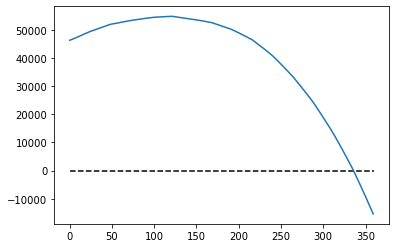

In [29]:
plt.plot(cumulativeList)
plt.hlines(y=0, xmin=0, xmax=len(cumulativeList), linestyle = '--')
plt.show()

In [15]:
myPayments = populateInterestRate(myPayments)
myPayments.head()

,PaymentDate,Instalment,Gross,interestRate,totalPayment,cumulativeTotal
0,2014-09-25,1,1191.3,0.055,1256.8215,1256.8215
1,2014-10-15,1,2250.0,0.055,2373.7500,2373.7500
2,2015-01-05,2,1191.3,0.055,1256.8215,1256.8215
3,2015-02-04,2,2250.0,0.055,2373.7500,2373.7500
4,2015-04-20,3,1227.4,0.055,1294.9070,1294.9070
